# Use transfer-learning with huggingface-transformers library

## Load data and make it accessible for huggingface environment

In [84]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from transformers import (AutoTokenizer, 
                          TFAutoModel,
                          TFAutoModelForSequenceClassification
                          )
from datasets import Dataset, DatasetDict, load_from_disk # to use huggingface datasets
from detector.utils import load_data, divide_frame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks, Model
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from joblib import dump, load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data = load_data()

In [5]:
train, val, test = (data["train"].reset_index(drop=True), 
                    data["valid"].reset_index(drop=True), 
                    data["test"].reset_index(drop=True))

def remove_newline(text: str) -> str:
    return text.replace("\n", " ")


for df in [train, val, test]:
    df["text"] = df["text"].apply(remove_newline)
    df["text_length"] = df['text'].apply(len)

In [6]:
train_small, train_medium, train_long = divide_frame(train)

In [7]:
for df in [train_small, train_medium, train_long]:
    print(df.shape[0])

train_sample = pd.concat([train_small.sample(10_000, random_state=1), 
                          train_medium.sample(20_000, random_state=1),
                          train_long.sample(10_000, random_state=1)]).reset_index(drop=True)

124936
250122
124942


In [8]:
train_sample

,text,AI,text_length
0,"""I didn't even know what a baby looked like un...",1,264
1,"In this video, watch as an electric eel can cl...",1,1043
2,"IOTA is divisible, fungible, durable , portabl...",0,529
3,× Report Chanel Preston And Ryan Ryans Just A ...,0,330
4,The best-selling film of 2012 starring Christi...,1,987
...,...,...,...
39995,"BANGUI, Central African Republic (AP) — A day ...",1,4709
39996,So what world view is under assault by populis...,0,5219
39997,This is a list of the most frequently asked qu...,1,5083
39998,Gerardo Mora/GettyImages. Mitt Romney has a p...,0,4951


In [9]:
ds_train = Dataset.from_pandas(train_sample, split="train")
ds_val = Dataset.from_pandas(val, split="valid")
ds_test = Dataset.from_pandas(test, split="test")

In [10]:
# pack datasets into a dictionary to tokenize them in parallel
ds_dict = DatasetDict({"train": ds_train, "valid": ds_val, "test": ds_test})

In [11]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'text_length'],
        num_rows: 40000
    })
    valid: Dataset({
        features: ['text', 'AI', 'text_length'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'text_length'],
        num_rows: 10000
    })
})

## Create Tokenizer suitable for the model

In [100]:
def model_checkpoint(name: str="distilbert", 
                     large: bool=True,
                     uncased: bool=True) -> str:
    model_ckpt = f'{name}-large' if large else f'{name}-base'
    return f'{model_ckpt}-uncased' if uncased else model_ckpt

model_ckpt = model_checkpoint(name="roberta",large=True, uncased=False)
# define the tokenizer the model was trained with
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_ckpt

'roberta-large'

In [101]:
tokenizer("this is a test!", return_tensors="tf")

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[   0, 9226,   16,   10, 1296,  328,    2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [102]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [103]:
# define a tokenize function that tokenizes the text in batches
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [104]:
ds_encoded = ds_dict.map(tokenize, batched=True, batch_size=10_000)

In [105]:
ds_encoded["train"].column_names

['text', 'AI', 'text_length', 'input_ids', 'attention_mask']

## Option 1: Use pre-trained model as feature extractor

### Extracting last hidden layer of a BERT model

For this approach the model-weights of our RoBERTA model are frozen and provide features for a classifier 

In [106]:
model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True) # load the model from the checkpoint

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [107]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="tf")
outputs = model(**inputs)
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 6, 1024), dtype=float32, numpy=
array([[[ 0.04603524, -0.00462841,  0.01070017, ..., -0.05166832,
          0.10207281,  0.06168523],
        [ 0.16665468, -0.10331246, -0.35997272, ...,  0.06356603,
         -0.1478664 ,  0.08259304],
        [ 0.36435974, -0.06037583, -0.32145458, ...,  0.09165369,
          0.07294382,  0.12116899],
        [-0.08846132, -0.09831417,  0.01492194, ..., -0.04664286,
         -0.18895282,  0.1724447 ],
        [ 0.07978453, -0.15301354, -0.12229724, ..., -0.16046473,
          0.11752793,  0.00620504],
        [ 0.06696582, -0.0087914 ,  0.03385552, ..., -0.0685569 ,
          0.08994152,  0.01962573]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[ 0.15439375,  0.71824986,  0.45034176, ..., -0.00599452,
         0.40904945, -0.3544111 ]], dtype=float32)>, past_key_values=None, hidden_states=None, attentions=None, cross_at

In [108]:
outputs.last_hidden_state.shape #output [batch_size, n_tokens, hidden_dim]

TensorShape([1, 6, 1024])

In [109]:
# for classification it is common practice use hidden state associated to start 
# of sequence token
outputs.last_hidden_state[:, 0].shape 

TensorShape([1, 1024])

In [110]:
# extract last hidden state for whole dataset
def extract_hidden_states(batch):
    inputs = {k: v for k,v in batch.items() if k in tokenizer.model_input_names}
    last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].numpy()}

In [111]:
ds_encoded.set_format("tensorflow", columns=["input_ids", "attention_mask", "AI"])

In [112]:
extract_hidden_states(ds_encoded["train"][:2])

{'hidden_state': array([[-0.33420086, -0.16058649, -0.16484469, ...,  0.27835876,
         -0.0556819 ,  0.37149817],
        [-0.16613328, -0.23028064, -0.22600123, ...,  0.29751363,
         -0.30976388,  0.5156858 ]], dtype=float32)}

In [113]:
ds_hidden = ds_encoded.map(extract_hidden_states, batched=True, batch_size=50)

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [114]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 40000
    })
    valid: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

In [115]:
ds_hidden.save_to_disk(f"hidden_states_{model_ckpt}")

In [116]:
ds_hidden = load_from_disk(f"hidden_states_{model_ckpt}")

In [117]:
ds_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 40000
    })
    valid: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'AI', 'text_length', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 10000
    })
})

-----

### Preparing data to train model

We are now using these hidden states to train a relatively simple classifier to predict if text is AI written or not.

In [27]:
X_train = np.array(ds_hidden["train"]["hidden_state"])
X_val = np.array(ds_hidden["valid"]["hidden_state"])
X_test = np.array(ds_hidden["test"]["hidden_state"])

y_train = np.array(ds_hidden["train"]["AI"])
y_val = np.array(ds_hidden["valid"]["AI"])
y_test = np.array(ds_hidden["test"]["AI"])

In [28]:
X_train

array([[ 0.17704922,  0.00966936, -0.16979757, ..., -0.05526693,
         0.26920223,  0.255841  ],
       [-0.20750733, -0.3828969 , -0.23853931, ..., -0.06183667,
         0.51362616,  0.57837814],
       [-0.14452401, -0.04512678,  0.01497217, ..., -0.13479084,
         0.0740034 ,  0.64472616],
       ...,
       [-0.20454003, -0.07451978, -0.3736105 , ..., -0.06127113,
         0.49450588,  0.55551225],
       [-0.16704421, -0.33564562, -0.4231589 , ...,  0.08641999,
         0.61370015,  0.44469708],
       [-0.05228056, -0.08852108, -0.20443952, ..., -0.14951706,
         0.6424493 ,  0.36885926]], dtype=float32)

In [29]:
X_train.shape, y_train.shape

((40000, 768), (40000,))

In [30]:
X_search = np.vstack((X_train, X_val))
y_search = np.hstack((y_train, y_val))

In [31]:
X_search.shape, y_search.shape
split = PredefinedSplit([-1]*X_train.shape[0]+[0]*X_val.shape[0])

In [32]:
scores_model = {}

### Logistic Regression

In [33]:
lr_clf = LogisticRegression(max_iter=5000)

params = {"C":[2**k for k in range(-2, 5)]}

search = GridSearchCV(lr_clf,
                      param_grid=params,
                      n_jobs=-1,
                      cv = split,
                      scoring="accuracy")

In [34]:
search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1, 2, 4, 8, 16]}, scoring='accuracy')

In [35]:
lr_clf_best = search.best_estimator_

In [36]:
lr_clf_best.fit(X_train, y_train)

In [87]:
dump(lr_clf_best, f"trained_models/lr_clf_best_{model_ckpt}.joblib")

['trained_models/lr_clf_best_distilbert-base-uncased.joblib']

In [88]:
scores_model["logistic_regression"] = lr_clf_best.score(X_test, y_test)
scores_model["logistic_regression"]

0.871

### SVM Classifier

In [38]:
#from sklearn.svm import SVC

In [39]:
# svc = SVC(random_state=1)

# params_svc = {
#     'C': [0.5, 1, 2],
#     #'degree': 3,
#     'kernel': ['linear']
#  }

# search_svc = GridSearchCV(
#     svc,
#     param_grid=params_svc,
#     n_jobs=-1,
#     cv=split,
#     scoring="accuracy"
# )

In [40]:
# search_svc.fit(X_search, y_search)

In [41]:
# search_svc.best_score_

In [42]:
# svc_best = search_svc.best_estimator_

In [43]:
# svc_best.fit(X_train, y_train)

In [44]:
# svc_best.score(X_test, y_test)

### Random Forest Classifier

In [45]:
#from sklearn.ensemble import RandomForestClassifier

In [46]:
#rf_clf = RandomForestClassifier(random_state=1, verbose=1, n_jobs=-1)

In [47]:
# params_rf = {
#  'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]
#  }

# random_search = RandomizedSearchCV(rf_clf,
#                                    param_distributions=params_rf,
#                                    n_iter=5,
#                                    scoring="accuracy",
#                                    n_jobs=-1,
#                                    cv=split)

In [85]:
# random_search.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/michaelfiedler/.pyenv/versions/3.10.6/envs/AI_written_text_identifier/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features=

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                                    verbose=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='accuracy')

In [48]:
#random_search.best_score_

### Gradient Boosting

In [50]:
from xgboost import XGBClassifier

In [52]:
xgb_clf = XGBClassifier(booster = 'gblinear', 
                        n_estimators=1000, 
                        seed=1, 
                        random_state=1)
#xgb_clf.get_params()

In [53]:
params_xgb = {
    'reg_lambda': [k*0.1 for k in range(11)]
    }

search_xgb = GridSearchCV(
    xgb_clf,
    param_grid=params_xgb,
    n_jobs=-1,
    cv=split,
    scoring="accuracy"
)

In [54]:
search_xgb.fit(X_search, y_search)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster='gblinear',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'reg_lambda': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                        0.5, 0.6000000000000001,
                                        0.7000000000000001, 0.8, 0.9, 1.0]},
             scoring='accuracy')

In [55]:
xgb_best = search_xgb.best_estimator_

In [56]:
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [89]:
dump(xgb_best, f"trained_models/xgb_best_{model_ckpt}.joblib.dat")

['trained_models/xgb_best_distilbert-base-uncased.joblib.dat']

In [91]:
scores_model["xgb"] = xgb_best.score(X_test, y_test)

In [92]:
scores_model["xgb"]

0.8699

### Ridge Classification

In [59]:
from sklearn.linear_model import RidgeClassifierCV

In [60]:
ridge_clf = RidgeClassifierCV(alphas=[0.99,0.1, 0.11], cv=split)

ridge_clf.fit(X_search, y_search)

RidgeClassifierCV(alphas=[0.99, 0.1, 0.11],
                  cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])))

In [93]:
dump(ridge_clf, f"trained_models/ridge_clf_{model_ckpt}.joblib")

['trained_models/ridge_clf_distilbert-base-uncased.joblib']

In [94]:
scores_model["ridge"] = ridge_clf.score(X_test, y_test)

In [95]:
scores_model["ridge"]

0.8719

### Simple NN

In [68]:
nn_inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation='gelu')(nn_inputs)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='gelu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
nn_model = Model(inputs=nn_inputs, outputs = outputs, name="basic_nn")
nn_model.summary()

Model: "basic_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                49216     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 53441 (208.75 KB)
Trainable params: 53441 (208.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
num_epochs = 100
num_train_examples = X_train.shape[0]
batch_size = 32
init_lr = 5e-4

decay_steps = num_train_examples // batch_size

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr,
                                                    decay_steps=decay_steps,
                                                    decay_rate=0.9)

es = callbacks.EarlyStopping(monitor="val_binary_accuracy",
                             mode="max",
                             patience=5,
                             restore_best_weights=True)

nn_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[keras.metrics.BinaryAccuracy()],
                 optimizer = optimizers.Adam(lr_schedule))

In [70]:
history = nn_model.fit(X_train, y_train,
             batch_size=batch_size,
             epochs=num_epochs,
             validation_data=(X_val, y_val),
             callbacks=[es])

Epoch 1/100


2023-06-23 17:40:45.210349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s - loss: 0.4187 - binary_accuracy: 0.8084

2023-06-23 17:40:54.039326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step - loss: 0.4183 - binary_accuracy: 0.8086 - val_loss: 0.3592 - val_binary_accuracy: 0.8426
Epoch 2/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3411 - binary_accuracy: 0.8500 - val_loss: 0.3357 - val_binary_accuracy: 0.8541
Epoch 3/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3208 - binary_accuracy: 0.8628 - val_loss: 0.3019 - val_binary_accuracy: 0.8716
Epoch 4/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3056 - binary_accuracy: 0.8698 - val_loss: 0.3406 - val_binary_accuracy: 0.8478
Epoch 5/100
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2926 - binary_accuracy: 0.8768 - val_loss: 0.2942 - val_binary_accuracy: 0.8737
Epoch 6/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2839 - binary_accuracy: 0.8791 - val_loss: 0.2905 - val_binary_accuracy: 0.8736
Epoch 7/100
1250/1250 [==============================] - 

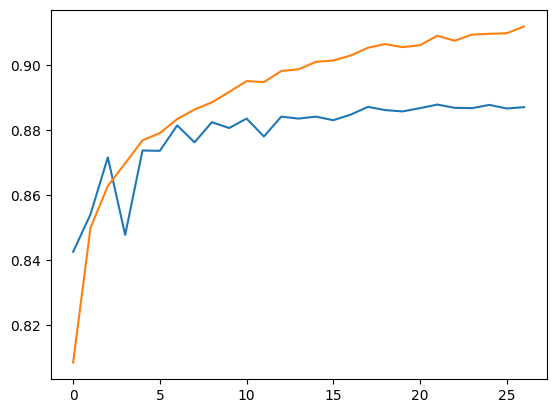

In [71]:
plt.plot(history.history["val_binary_accuracy"])
plt.plot(history.history["binary_accuracy"]);

In [72]:
scores_model["neural_network"] = {"score": nn_model.evaluate(X_test, y_test)[1],
                                  "model": nn_model}

313/313 [==============================] - 1s 5ms/step - loss: 0.2749 - binary_accuracy: 0.8834


In [73]:
scores_model["neural_network"]

{'score': 0.883400022983551,
 'model': <keras.src.engine.functional.Functional at 0x459f31510>}

In [74]:
nn_model.save(f"nn_model_{model_ckpt}")

INFO:tensorflow:Assets written to: nn_model_distilbert-base-uncased/assets


INFO:tensorflow:Assets written to: nn_model_distilbert-base-uncased/assets


## Get Prediction for input text

In [75]:
test_text = '''In recent years, we have witnessed a remarkable revolution in the field of artificial intelligence (AI). 
The rapid advancements in machine learning and neural networks have unlocked unprecedented capabilities, enabling AI 
systems to perform complex tasks and mimic human intelligence with remarkable accuracy. 
This revolution has had a profound impact on various aspects of our lives, including communication, entertainment, 
and information dissemination.'''
#nn_model.predict(model(**tokenizer(test_text, return_tensors='tf')).last_hidden_state[:,0].numpy())[0][0]
lr_clf_best.predict_proba(model(**tokenizer(test_text, return_tensors='tf')).last_hidden_state[:,0].numpy())[0][1]

0.9581640348759896

In [99]:
def get_prediction(text_input: str, model_name: str="nn") -> float:
    '''outputs the probability of the text being AI written
    ---
    text_input: text to be classified
    ---
    model_name: model to be used for classification. Options are "nn" 
    for neural network, "xgb" for xgboost,
    "lr" for logistic regression, "ridge" for ridge classifier.
    '''
    inputs = tokenizer(text_input, return_tensors="tf")
    outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state[:, 0].numpy()
    proba = None
    class_pred = None
    if model_name == "nn":
        nn_model = keras.models.load_model(f"nn_model_{model_ckpt}")
        proba = nn_model.predict(hidden_states, verbose=0)[0][0]
    elif model_name == "lr":
        lr_clf_best = load(f"trained_models/lr_clf_best_{model_ckpt}.joblib")
        proba = lr_clf_best.predict_proba(hidden_states)[0][1]
    elif model_name == "ridge":
        ridge_clf = load(f"trained_models/ridge_clf_{model_ckpt}.joblib")
        proba = ridge_clf.decision_function(hidden_states)[0]
    elif model_name == "xgb":
        xgb_best = load(f"trained_models/xgb_best_{model_ckpt}.joblib.dat")
        proba = xgb_best.predict_proba(hidden_states)[0][1]
    else:
        raise ValueError("model must be one of 'nn', 'lr' or 'ridge'")
    if proba > 0.5:
        class_pred = "AI written"
    else:
        class_pred = "not AI written"
    print(f'''Probability of text being AI written: {proba:.2f}
The prediction therfore is that the text is {class_pred}''')
    return proba, class_pred

In [98]:
get_prediction(test_text, model_name="nn")

Probability of text being AI written: 0.97
The prediction therfore is that the text is AI written


2023-06-23 18:23:35.253961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(0.96681577, 'AI written')